In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
df = pd.read_csv('creditcard.csv')
print(df.shape)

(284807, 31)


Time variable
284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

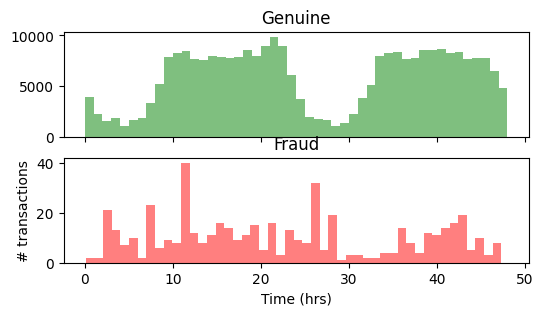

In [ ]:
print("Time variable")
df["Time_Hr"] = df["Time"]/3600 # convert to hours
print(df["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')
# The 'Time' feature was converted into hourly units as 'Time_Hr' for visual analysis,
# and since both genuine and fraudulent transactions show a similar pattern—more frequent during daytime and less frequent at night
# 'Time_Hr' alone may not offer strong discriminative power for classification, so for clarity and simplicity, we retain 'Time_Hr' while dropping the original 'Time' column.

In [ ]:
df = df.drop(['Time'],axis=1)

Text(0, 0.5, '# transactions')

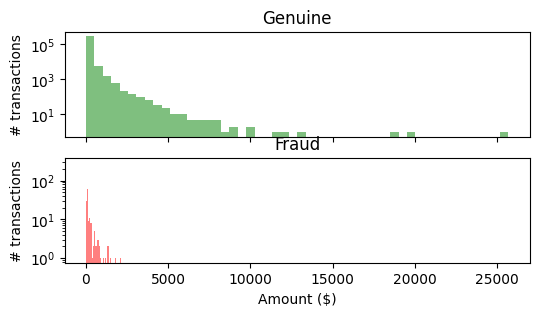

In [ ]:
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')
#Since fraudulent transactions rarely occur when the transaction amount is around $10,000 or higher,
#we will later compare the model's performance with and without the Amount feature.

In [ ]:
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)
# The 'Amount' feature is on a different scale compared to the other principal components(V1~V28),
# so it will be standardized using StandardScaler and stored in the dataframe for later use.

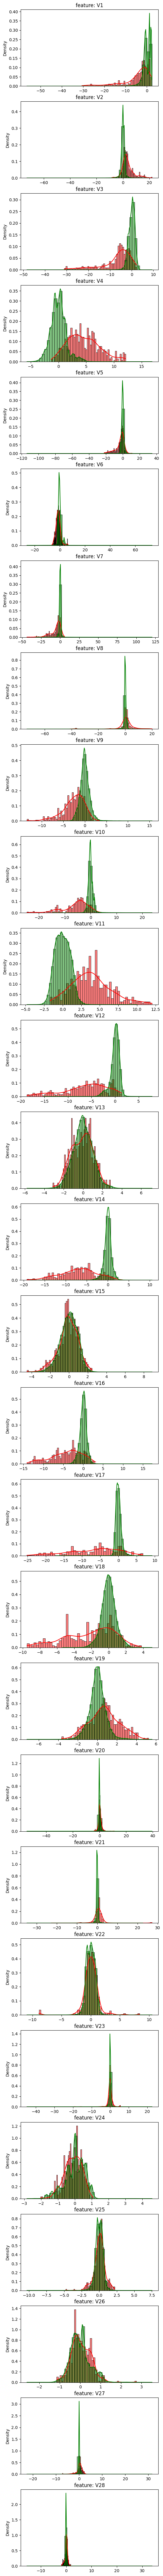

In [ ]:
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.histplot(df[col][df.Class == 1], bins=50, color='r', stat='density', kde=True)
    sns.histplot(df[col][df.Class == 0], bins=50, color='g', stat='density', kde=True)
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()
#Features among V1 to V28 that show similar distributions for both genuine and fraudulent transactions
#will be removed to reduce the risk of overfitting and potentially improve model performance.
# 'V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28' are considered to have similar distributions between the classes.

In [ ]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test
print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')


In [ ]:
def get_predictions(clf, X_train, y_train, X_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred))
    return y_pred, y_pred_prob
#This function trains the given classifier on the training data, returns the predicted labels and probabilities for the test data, and prints the confusion matrix for the training set.

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Case-1 : do not drop anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
a1=confusion_matrix(y_test,y_pred)
a2=recall_score(y_test,y_pred)
a3=precision_score(y_test,y_pred)
a4=f1_score(y_test,y_pred)
a5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', a1)
print("recall score: ", a2)
print("precision score: ", a3)
print("f1 score: ", a4)
print("accuracy score: ", a5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[222480   4971]
 [    69    325]]
test-set confusion matrix:
 [[55535  1329]
 [   15    83]]
recall score:  0.8469387755102041
precision score:  0.058781869688385266
f1 score:  0.10993377483443709
accuracy score:  0.9764053228468101
ROC AUC: 0.963247971529636


In [ ]:
# Case-2 : drop # Case-NB-2 : drop 'V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28'
drop_list = ['V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
b1=confusion_matrix(y_test,y_pred)
b2=recall_score(y_test,y_pred)
b3=precision_score(y_test,y_pred)
b4=f1_score(y_test,y_pred)
b5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', b1)
print("recall score: ", b2)
print("precision score: ", b3)
print("f1 score: ", b4)
print("accuracy score: ", b5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223971   3480]
 [    61    333]]
test-set confusion matrix:
 [[55938   926]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08498023715415019
f1 score:  0.15495495495495495
accuracy score:  0.9835328815701696
ROC AUC: 0.961731822723462


In [ ]:
# Case-3 : drop some of principle components + Time
drop_list = ['Time_Hr','V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
c1=confusion_matrix(y_test,y_pred)
c2=recall_score(y_test,y_pred)
c3=precision_score(y_test,y_pred)
c4=f1_score(y_test,y_pred)
c5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', c1)
print("recall score: ", c2)
print("precision score: ", c3)
print("f1 score: ", c4)
print("accuracy score: ", c5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223973   3478]
 [    61    333]]
test-set confusion matrix:
 [[55935   929]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08472906403940887
f1 score:  0.1545372866127583
accuracy score:  0.9834802148800955
ROC AUC: 0.9609825412297728


In [ ]:
# Case-4 : drop some of principle components + 'scaled_Amount'
drop_list = ['scaled_Amount','V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
d1=confusion_matrix(y_test,y_pred)
d2=recall_score(y_test,y_pred)
d3=precision_score(y_test,y_pred)
d4=f1_score(y_test,y_pred)
d5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', d1)
print("recall score: ", d2)
print("precision score: ", d3)
print("f1 score: ", d4)
print("accuracy score: ", d5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224038   3413]
 [    61    333]]
test-set confusion matrix:
 [[55958   906]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08669354838709678
f1 score:  0.1577981651376147
accuracy score:  0.9838839928373302
ROC AUC: 0.9615902389374433


In [ ]:
# Case-5 : drop some of principle components + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time_Hr','V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
e1=confusion_matrix(y_test,y_pred)
e2=recall_score(y_test,y_pred)
e3=precision_score(y_test,y_pred)
e4=f1_score(y_test,y_pred)
e5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', e1)
print("recall score: ", e2)
print("precision score: ", e3)
print("f1 score: ", e4)
print("accuracy score: ", e5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224030   3421]
 [    60    334]]
test-set confusion matrix:
 [[55957   907]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.0866062437059416
f1 score:  0.15765352887259396
accuracy score:  0.9838664372739722
ROC AUC: 0.9607475552122932


In [ ]:
scores = {
    "Case-1": {"recall": a2, "precision": a3,  "f1": a4, "accuracy": a5},
    "Case-2": {"recall": b2, "precision": b3,  "f1": b4, "accuracy": b5},
    "Case-3": {"recall": c2, "precision": c3,  "f1": c4, "accuracy": c5},
    "Case-4": {"recall": d2, "precision": d3,  "f1": d4, "accuracy": d5},
    "Case-5": {"recall": e2, "precision": e3,  "f1": e4, "accuracy": e5},
}

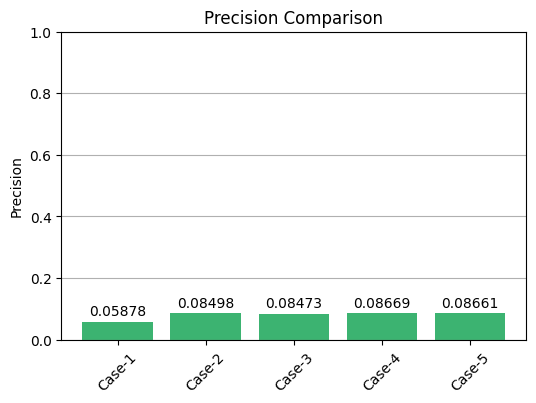

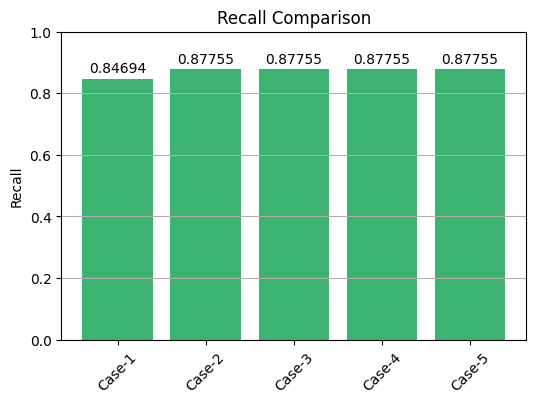

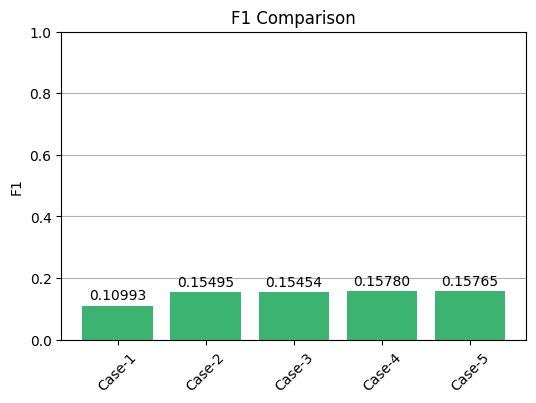

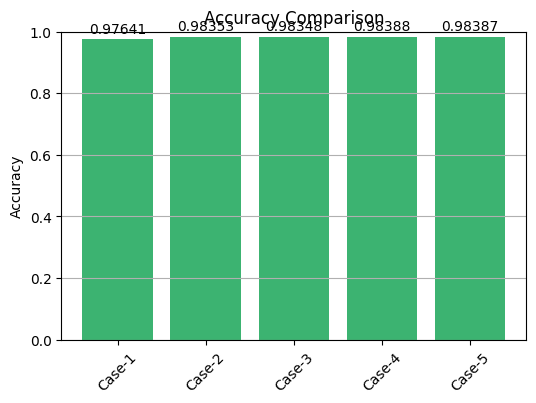

In [ ]:
for metric in metrics:
    plt.figure(figsize=(6, 4))


    bars = plt.bar(cases, values_by_metric[metric], color='mediumseagreen')

    plt.ylim(0, 1)
    plt.title(f"{metric.capitalize()} Comparison")
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)


    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.5f}", ha='center', va='bottom')

    plt.grid(axis='y')
    plt.show()

In [ ]:
# 먼저 Time, V1~V28, Amount의 정상 거래와 사기 거래 간 분포를 시각화하여 유의미한 차이가 있는지를 사전에 분석했습니다.
# 그 결과 Time과 'V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28' 총 12개의 피처는
# 정상 거래와 사기 거래 간의 구분이 뚜렷하지 않아 예측 성능에 큰 도움이 되지 않을 것으로 예상했습니다.
# 반면, Amount는 10000달러 이상의 고액 거래에서 사기 거래가 발생하지 않는다는 점에서 구분에 중요한 역할을 할 것으로 기대했습니다.

# 이에 따라 총 5개의 Case를 구성하여 Naive Bayes 모델을 이용해 성능을 비교했습니다:
# 1) 아무 것도 제외하지 않은 경우
# 2) PCA 성분 12개만 제거한 경우
# 3) PCA 성분 12개 + Time 제거
# 4) PCA 성분 12개 + Amount 제거
# 5) PCA 성분 12개 + Time + Amount 제거
# 비교 결과, Case 1과 Case 2를 비교했을 때 불필요한 12개 PCA 성분을 제거한 Case 2에서 성능이 향상되었고,
# Case 2와 Case 4 비교에서는 Amount를 제거했을 때 오히려 예측 성능이 더 좋아졌습니다.
# 반면, Case 2와 3, Case 4와 5를 비교해보면 Time을 제거했을 때 소폭의 성능 저하가 나타났습니다.

# 따라서 'V6','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28'과 Amount는
# 모델 성능을 방해하거나 기여도가 낮은 불필요한 변수로 판단되며,
# Time은 단독으로는 큰 영향은 없지만, 다른 피처들과 결합할 경우 약간의 보완 효과를 줄 수 있는 보조적인 변수로 해석됩니다.

In [ ]:
# We began by visually analyzing the distributions of the Time, V1–V28, and Amount features
# to assess whether there were meaningful differences between genuine and fraudulent transactions.

# Based on the distribution plots, 12 features — 'V6', 'V8', 'V13', 'V15', 'V20', 'V22',
# 'V23', 'V24', 'V25', 'V26', 'V27', and 'V28' — showed little distinction between the two classes,
# suggesting that they may not contribute meaningfully to prediction.
# In contrast, the Amount feature was initially expected to be important, as no frauds were observed
# in transactions over $10,000.

# We then defined five experimental cases to evaluate model performance using Gaussian Naive Bayes:
# 1) No features removed
# 2) 12 PCA features removed
# 3) 12 PCA features + Time removed
# 4) 12 PCA features + Amount removed
# 5) 12 PCA features + Time + Amount removed

# Results showed that removing the 12 PCA components (Case 2) improved prediction performance
# compared to Case 1, and further removing the Amount feature (Case 4) led to the best overall results.
# However, when Time was removed (Case 3 and 5), performance slightly declined,
# suggesting that Time may still provide some auxiliary value when used in combination with other features.

# In conclusion, the 12 PCA components listed above and the Amount feature can be considered unnecessary
# for this model, while Time is not a major predictor on its own but may support the model
# by enhancing prediction when combined with other features.